In [1]:
import math 
import numpy as np 
import pandas as pd 
#import scikitplot 
import seaborn as sns 
from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf 
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,Dense,MaxPool2D,Dropout,BatchNormalization,LeakyReLU,Activation
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


2024-03-14 18:55:01.300024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 18:55:01.300128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 18:55:01.434600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df=pd.read_csv('/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [4]:
emotion_label_to_text= {0:'anger', 1:'disgust', 2:'fear',
                        3:'happiness', 4: 'sadness', 
                        5: 'surprise', 6: 'neutral'}

In [5]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

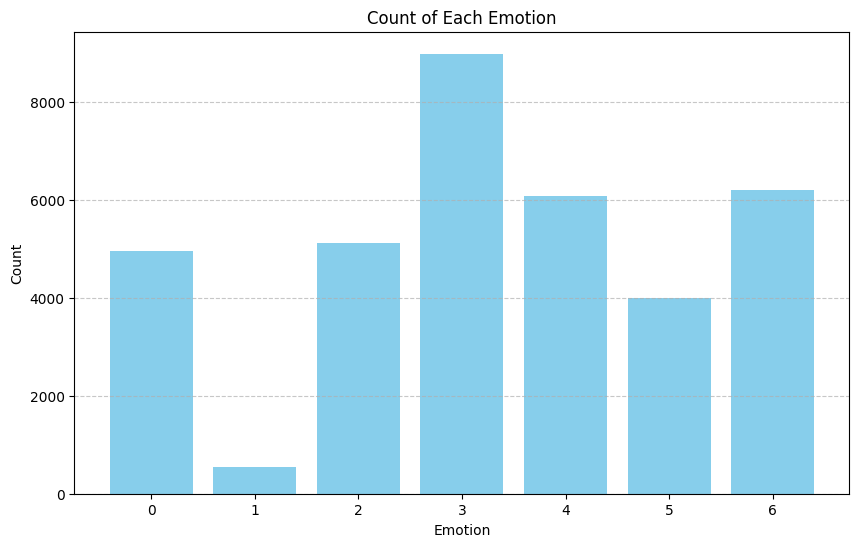

In [6]:
import matplotlib.pyplot as plt

# Define the emotion labels and their corresponding counts
emotion_labels = [3, 6, 4, 2, 0, 5, 1]
counts = [8989, 6198, 6077, 5121, 4953, 4002, 547]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotion_labels, counts, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Count of Each Emotion')
plt.xticks(emotion_labels)  # Set x-axis ticks to be the emotion labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral and we are also intersted in these three classes only.

In [7]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

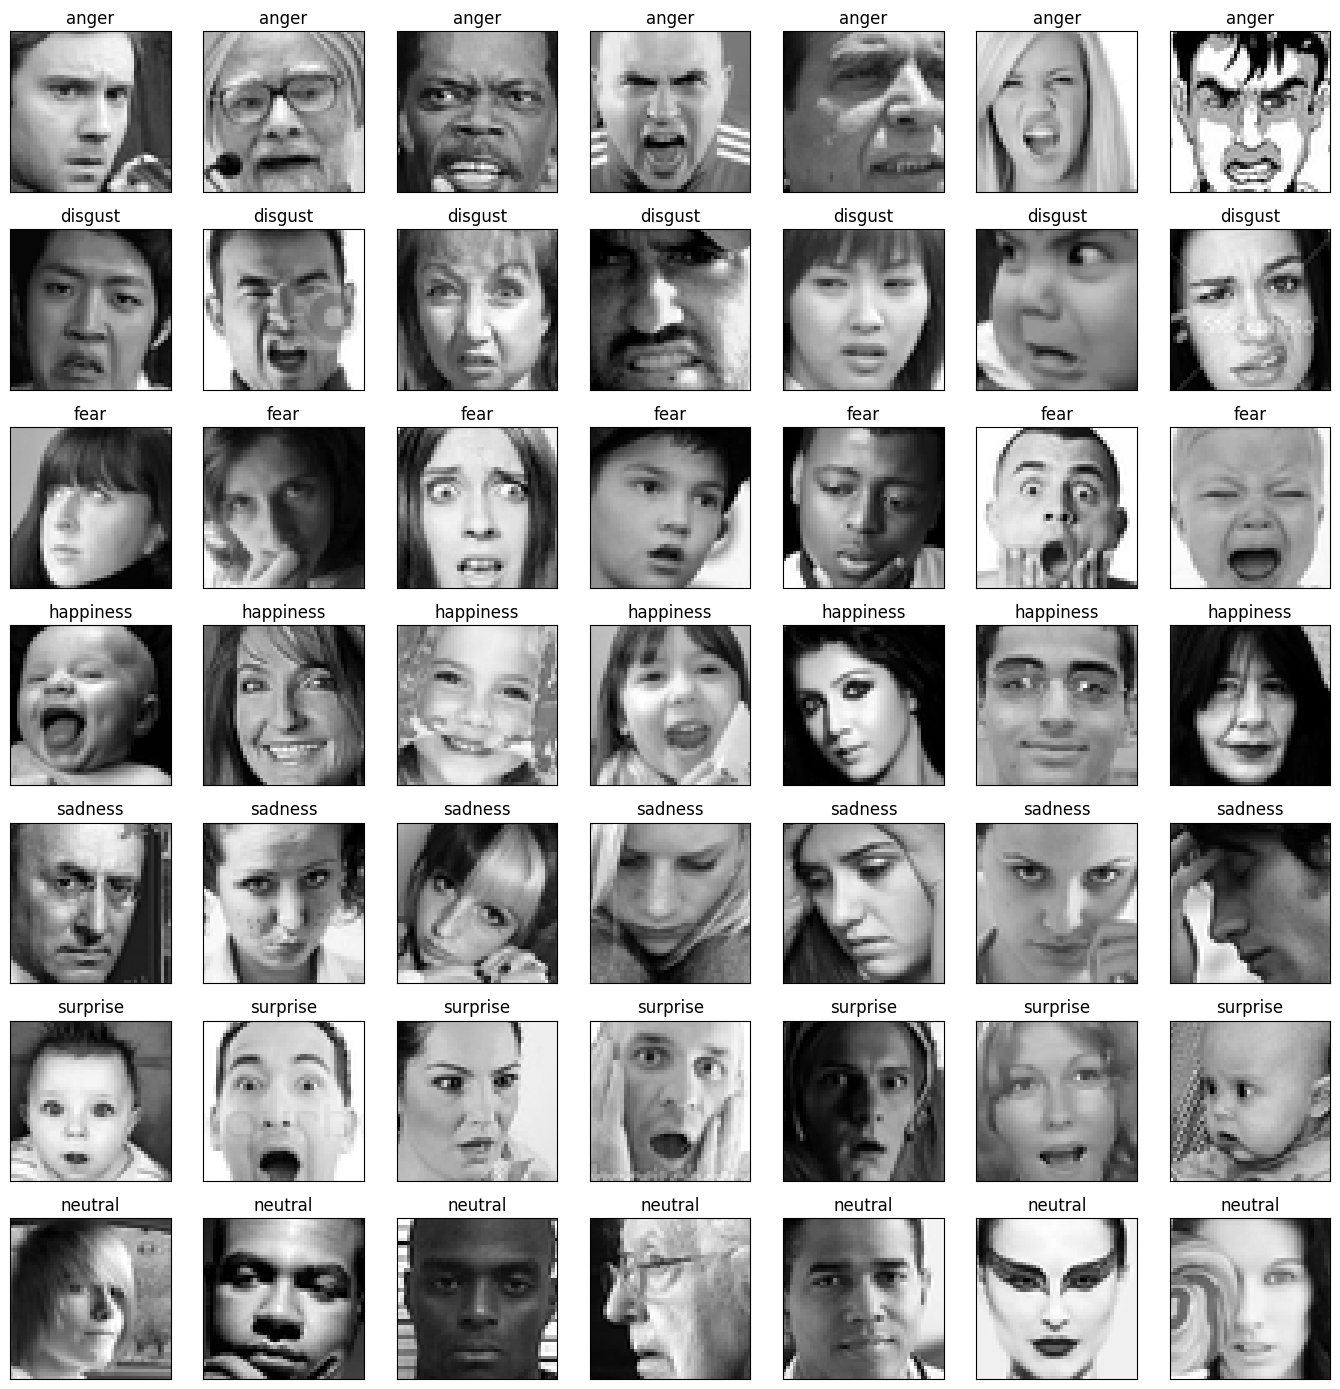

In [8]:
fig=plt.figure(1,(14,14))

k=0

for label in sorted(df.emotion.unique()):
    for j in range(7):
        px=df[df.emotion==label].pixels.iloc[k]
        px=np.array(px.split(' ')).reshape(48,48).astype('float32')
        
        k+=1
        ax=plt.subplot(7,7,k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [9]:
INTERSTED_LABELS=[3,4,6]

In [10]:
df=df[df.emotion.isin(INTERSTED_LABELS)]
df.shape

(21264, 3)

#Now i will make the data compatible for neural network

In [11]:
img_array=df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
img_array=np.stack(img_array,axis=0)

In [12]:
img_array.shape

(21264, 48, 48, 1)

In [13]:
le=LabelEncoder()
img_labels=le.fit_transform(df.emotion)
img_labels=to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [14]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [15]:
# Splitting the data inti training and valodation set 

X_train, X_valid, y_train, y_valid=train_test_split(img_array,img_labels,shuffle=True,stratify=img_labels,test_size=0.1,
                                                    random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [16]:
del df 
del img_array
del img_labels

In [17]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [18]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [19]:
def build_net(optim):
    net=Sequential(name='DCNN')
    net.add(Conv2D(filters=64,
                   kernel_size=(5,5),
                   input_shape=(img_width,img_height,img_depth),
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal',
                   name='con2d_1'
                   ))
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
        
                ))
    net.add(BatchNormalization(name='batchnorm_2'))
    net.add(MaxPool2D(pool_size=(2,2),name='maxpool2d_1'))
    net.add(Dropout(0.4, name='droupout_1'))
    net.add(Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
            
    ))
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
        
    ))
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    
    net.add(BatchNormalization(name='batchnorm_5'))
    
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPool2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='relu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(Dropout(0.6,name='droupout_4'))
    net.add(Dense(num_classes,
                  activation='softmax',
                  name='out_layer'))
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    return net
    
    
    

In [20]:
early_stopping=EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True
)

lr_scheduler=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)
callbacks=[early_stopping,
           lr_scheduler]

In [21]:
train_datagen=ImageDataGenerator(rotation_range=15,
                                 width_shift_range=0.15,
                                 height_shift_range=0.15,
                                 shear_range=0.15,
                                 zoom_range=0.15,
                                 horizontal_flip=True)
train_datagen.fit(X_train)

In [22]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
        optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
        optimizers.Adam(0.001)
]
steps_per_epoch = len(X_train) // batch_size

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks,
    #use_multiprocessing=True
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ con2d_1 (Conv2D)                │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droupout_1 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  5/598 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.3536 - loss: 2.1314

I0000 00:00:1710442591.473844      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710442591.497802      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


597/598 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3794 - loss: 1.4918

W0000 00:00:1710442613.509664      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


598/598 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.3795 - loss: 1.4912 - val_accuracy: 0.4960 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 2/100
  1/598 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.4688 - loss: 1.1156

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.4688 - loss: 1.1156 - val_accuracy: 0.4993 - val_loss: 1.0061 - learning_rate: 0.0010
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.4612 - loss: 1.0520 - val_accuracy: 0.5656 - val_loss: 0.9074 - learning_rate: 0.0010
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.5000 - loss: 0.9483 - val_accuracy: 0.5623 - val_loss: 0.9133 - learning_rate: 0.0010
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5405 - loss: 0.9424 - val_accuracy: 0.6070 - val_loss: 0.8292 - learning_rate: 0.0010
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.5312 - loss: 0.9534 - val_accuracy: 0.6159 - val_loss: 0.8173 - learning_rate: 0.0010
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5965 - loss: 0.8512 - val_accuracy: 0.6747 - val_loss: 0.7384 - learning_rate: 0.0010
Epoch 8/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.4375 - loss: 

In [23]:
model.save('Facial_emotion_recognition.h5')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

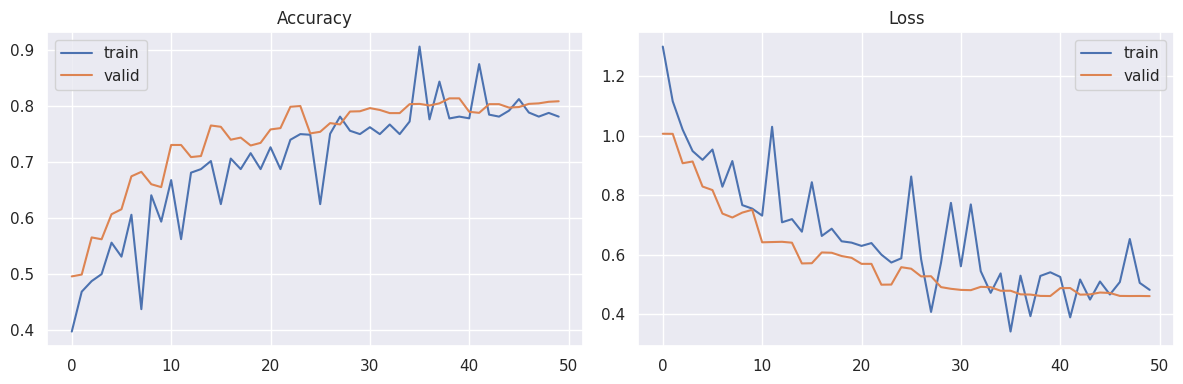

In [24]:
sns.set()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plotting accuracy
sns.lineplot(x=history.epoch, y=history.history['accuracy'], ax=axes[0], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], ax=axes[0], label='valid')
axes[0].set_title('Accuracy')

# Plotting loss
sns.lineplot(x=history.epoch, y=history.history['loss'], ax=axes[1], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], ax=axes[1], label='valid')
axes[1].set_title('Loss')

plt.tight_layout()
plt.savefig('epoch_history_dcnn.png')
plt.show()

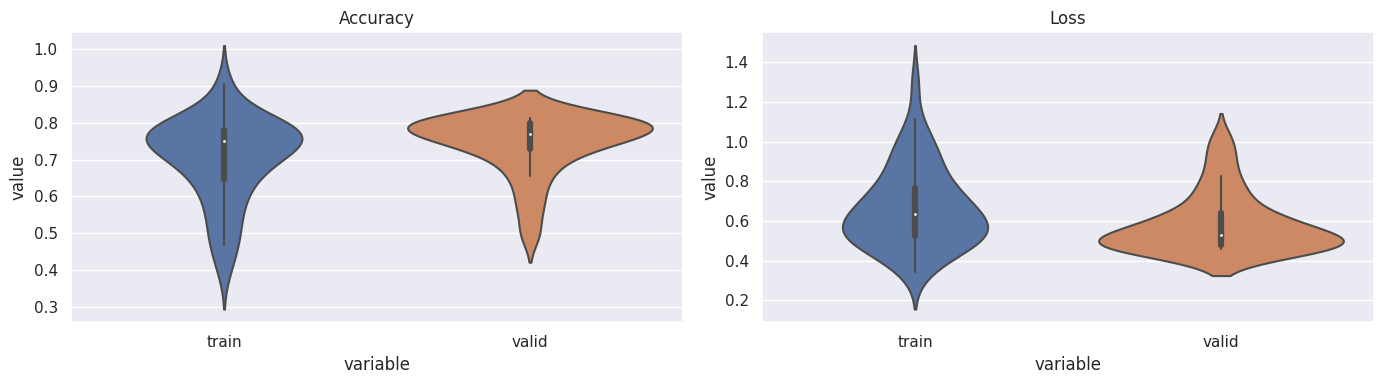

In [25]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = plt.figure(0, (14, 4))
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
plt.title('Loss')
plt.tight_layout()

plt.savefig('performance_dist.png')
plt.show()

In [26]:
pip install --upgrade scikit-plot scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2024.2.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incomp

In [27]:
pip install scikit-plot==0.3.7

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 46.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2024.2.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incomp

In [29]:
pip install scikit-plot scipy

Note: you may need to restart the kernel to use updated packages.


In [30]:
# Predict probabilities for validation data
yhat_valid_probs = model.predict(X_valid)
# Extract predicted classes by taking the index of the highest probability for each sample
yhat_valid = np.argmax(yhat_valid_probs, axis=1)
# Calculate and print classification report
print(f'Total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

16/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

W0000 00:00:1710443011.759735      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Total wrong validation predictions: 396

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       899
           1       0.79      0.69      0.74       608
           2       0.70      0.78      0.74       620

    accuracy                           0.81      2127
   macro avg       0.80      0.80      0.80      2127
weighted avg       0.82      0.81      0.81      2127



In [31]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


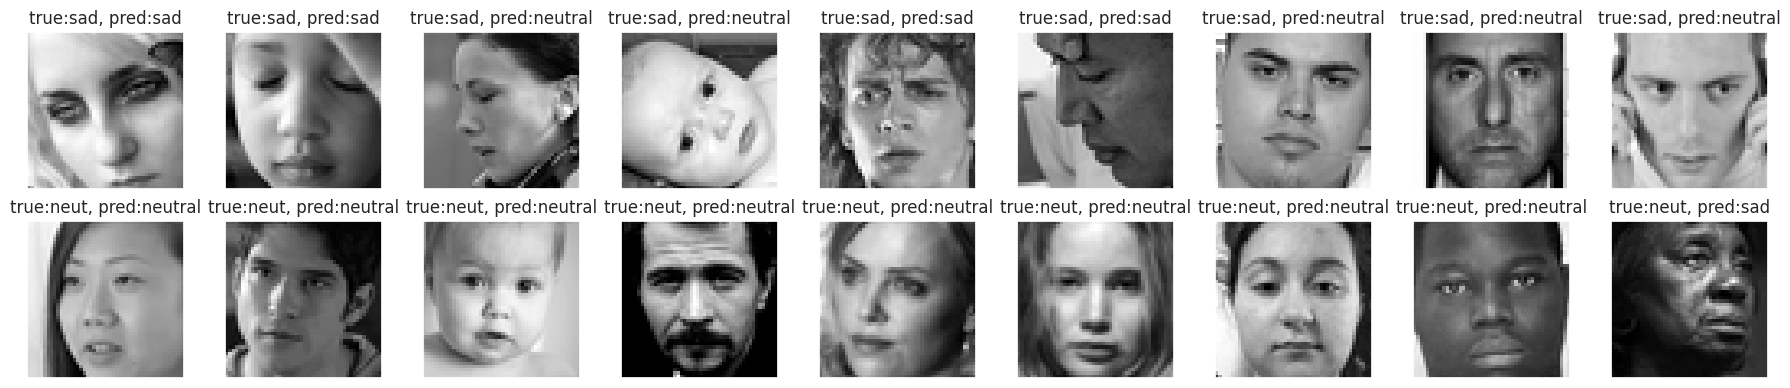

In [32]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = plt.subplot(2, 9, i+1)
    sample_img = X_valid[sadidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    pred_probs_sad = model.predict(sample_img.reshape(1, 48, 48, 1))[0]
    pred_class_sad = np.argmax(pred_probs_sad)
    ax.set_title(f"true:sad, pred:{mapper[pred_class_sad]}")

    ax = plt.subplot(2, 9, i+10)
    sample_img = X_valid[neuidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    pred_probs_neut = model.predict(sample_img.reshape(1, 48, 48, 1))[0]
    pred_class_neut = np.argmax(pred_probs_neut)
    ax.set_title(f"true:neut, pred:{mapper[pred_class_neut]}")

plt.tight_layout()
plt.show()
